# Dijkstra path finding algorithm

Created by - Sanjana Tule

Date - 26/08/2021

*   Run Dijkstra for path finding on graph.
*  Custom weight function - options are length/combined_risk or cobination of length + combined_risk




In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [2]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import math
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as mpatches


# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PART 2 - PATH FINDING USING ABSTRACT AND DETAILED GRAPH

In [5]:
# Load detailed graph and its nodes
graph_detailed = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
nodes_nr_all,edges = ox.graph_to_gdfs(graph_detailed)

# Calculate 2 new weight factors on the edges
edges['combined_risk_and_length'] = edges['combined_risk'] + edges['length']
edges['combined_risk_per_length'] = edges['combined_risk'] * edges['length']
display(edges.head())

# Make the graph again
graph_detailed = ox.graph_from_gdfs(nodes_nr_all,edges)

osmid  ... combined_risk_per_length
u          v          key                          ...                         
21569692   4682380491 0    [185913115, 401489878]  ...               636.251146
           6784129512 0                 401489883  ...                12.955000
           6784129514 0                 401489877  ...                20.032500
4682380491 21569692   0    [185913115, 401489878]  ...               636.251146
           4682381110 0                 474236841  ...               101.304831

[5 rows x 22 columns]

In [13]:
 ##################################### PART 2 - FIND THE ROUTE #################################################################
 ###############################################################################################################################

def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values.

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates

# euclidean distance
def get_euclidean_distance(s,geom):
    return ox.distance.euclidean_dist_vec(s[1],s[0],geom.bounds[1],geom.bounds[0])

# euclidean distance reverse
def get_euclidean_distance_r(s,geom):
    return ox.distance.euclidean_dist_vec(s[0],s[1],geom.bounds[1],geom.bounds[0])

# nearest park
def find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,type):
  nodes_park = graph_detailed_nodes[graph_detailed_nodes['evacuation_type']== type]
  euc_distance_parks = nodes_park.geometry.apply(lambda x: get_euclidean_distance_r(source_coordinates,x))
  return euc_distance_parks.sort_values().index.values[0]

# find shortest route
def find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_detailed_nodes):
  
  # find nearest node to the address in the detailed graph
  source_node, source_dist = ox.get_nearest_node(graph_detailed,source_coordinates,return_dist=True)
  #print('source node in detailed graph',source_node)

  # find the destination if not given
  if choice_of_destination == 1: # park
    dest_node = find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,'park')
    #print('Destination node in detailed graph',dest_node)
  elif choice_of_destination == 2: # shelter
    dest_node = find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,'shelter')
    #print('Destination node in detailed graph',dest_node)
  else:
    # find nearest node to the address in the detailed graph
    dest_node, dest_dist = ox.get_nearest_node(graph_detailed,destination_coordinates,return_dist=True)
    #print('Destination node in detailed graph',dest_node)
  
  # capture all paths and stats
  route_list = []
  collect_stat = []

  for weight_to_use in ['length','combined_risk_score','combined_risk_and_length','combined_risk_per_length']:
    print("Finding Path using weight:",weight_to_use)

    # record time
    start_time = time.time()

    # find the shortest path betwen destination node in detailed graph to the destination node in the abstract graph
    #complete_path = nx.shortest_path(G =graph_detailed,source=source_node, target=dest_node, weight=weight_to_use, method='dijkstra')
    complete_path = nx.astar_path(G=graph_detailed, source=source_node, target=dest_node, heuristic = None, weight=weight_to_use)
    #print("ROUTE",complete_path)
    route_list.append(complete_path)
    
    A_time = (time.time() - start_time)
    #print("TOTAL TIME",A_time)

    # length and risk
    total_length = sum(nx.Graph(graph_detailed)[u][v].get('length') for u, v in zip(complete_path[:-1], complete_path[1:]))
    total_risk = sum(nx.Graph(graph_detailed)[u][v].get('combined_risk') for u, v in zip(complete_path[:-1], complete_path[1:]))
    print("LENGTH OF THE ROUTE",total_length)
    print("RISK OF THE ROUTE",total_risk)
    collect_stat.append([round(A_time,2),round(total_length,2),round(total_risk,2)])

  # Plot stats in a table
  val1 = ['Total Time','Total Length','Total Risk'] 
  val2 = ['length','combined_risk_score','combined_risk_and_length','combined_risk_per_length'] 
  val3 = collect_stat
  
  fig, ax = plt.subplots(figsize=(15,10)) 
  ax.set_axis_off() 
  table = ax.table( 
      cellText = val3,  
      rowLabels = val2,  
      colLabels = val1, 
      rowColours =["palegreen"] * 4,  
      colColours =["palegreen"] * 3, 
      cellLoc ='center',  
      loc ='upper left')           
  ax.set_title('SUMMARY STATS', 
              fontweight ="bold") 
  plt.show() 

  # Plot route
  rc = ['r', 'y', 'b', 'g']
  fig, ax = ox.plot_graph_routes(graph_detailed,route_list, route_colors=rc, route_linewidth=10, route_alpha=0.5,node_size=1,bgcolor='white',figsize=(20,30), dpi=300,edge_alpha=0.50,node_color='black',show=False, close=False)
  ax.set_title('PATH FINDING USING DIFFERENT WEIGHT FACTORS USING A*')
  red_patch = mpatches.Patch(color='red', label='LENGTH')
  yellow_patch = mpatches.Patch(color='yellow', label='COMBINED RISK SCORE')
  blue_patch = mpatches.Patch(color='blue', label='COMBINED RISK SCORE + LENGTH')
  green_patch = mpatches.Patch(color='green', label='COMBINED RISK SCORE * LENGTH')
  plt.legend(handles=[red_patch, yellow_patch,blue_patch,green_patch])
  plt.show()

DEMO 1 - 
FIND PATH FOR CUSTOM DESTINATION

SOURCE: 19130 Tulsa St, Northridge, CA 91326
DESTINATION 7741 Hayvenhurst Ave, Van Nuys, CA 91406
Finding Path using weight: length
LENGTH OF THE ROUTE 10011.905000000006
RISK OF THE ROUTE 370.8533498759305
Finding Path using weight: combined_risk_score
LENGTH OF THE ROUTE 12413.135000000002
RISK OF THE ROUTE 164.18438496986883
Finding Path using weight: combined_risk_and_length
LENGTH OF THE ROUTE 10078.114000000001
RISK OF THE ROUTE 230.78518255937615
Finding Path using weight: combined_risk_per_length
LENGTH OF THE ROUTE 10382.779000000008
RISK OF THE ROUTE 250.1118220489188


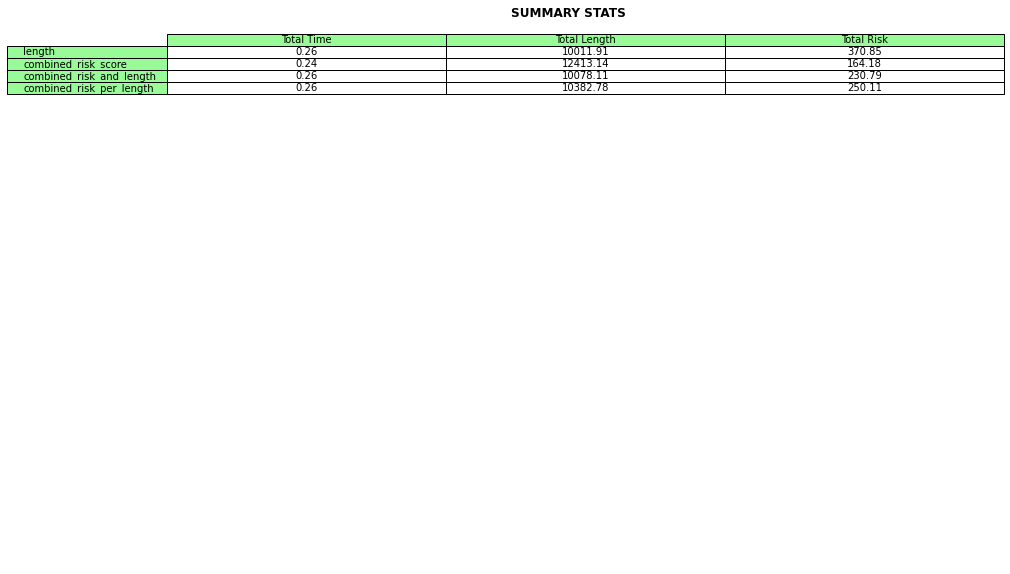

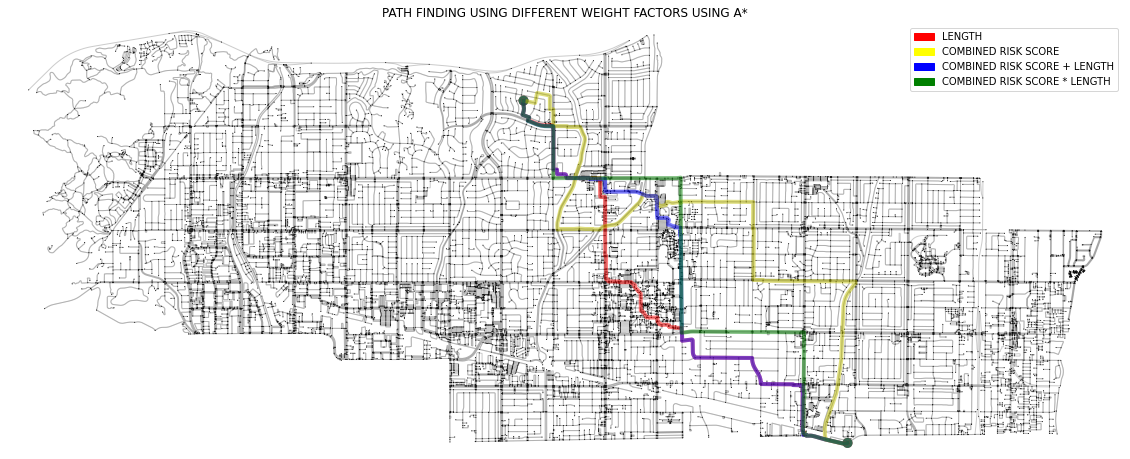

In [14]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address.')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "7741 Hayvenhurst Ave, Van Nuys, CA 91406"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)

print("SOURCE:",source_address)
print("DESTINATION",destination_address)

# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,nodes_nr_all)

Finding Path using weight: length
LENGTH OF THE ROUTE 20305.409
RISK OF THE ROUTE 494.4238213399503
Finding Path using weight: combined_risk_score
LENGTH OF THE ROUTE 22147.247
RISK OF THE ROUTE 259.51772421127254
Finding Path using weight: combined_risk_and_length
LENGTH OF THE ROUTE 20322.265000000003
RISK OF THE ROUTE 451.1949485997874
Finding Path using weight: combined_risk_per_length
LENGTH OF THE ROUTE 21345.643000000007
RISK OF THE ROUTE 307.03766394895416


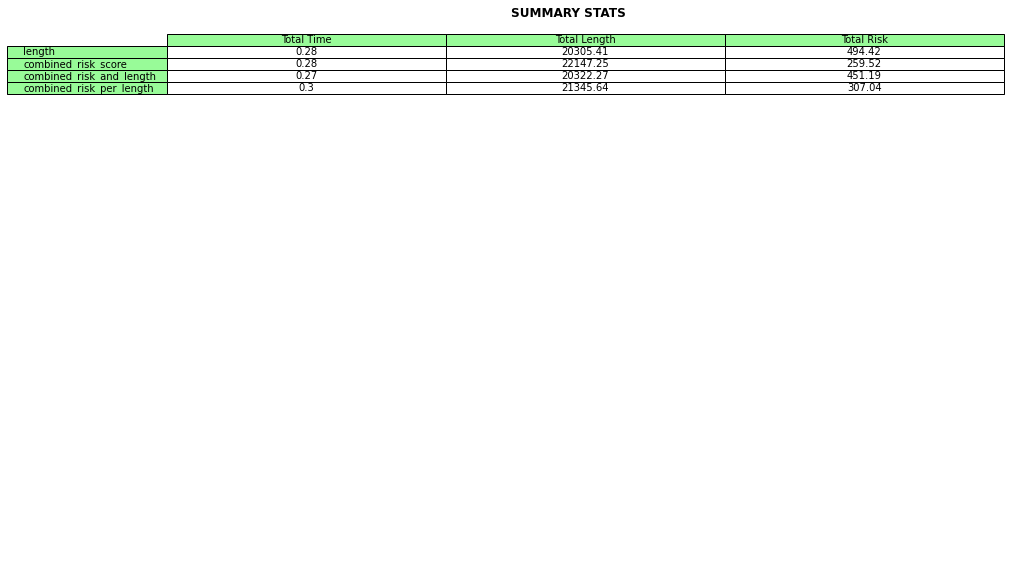

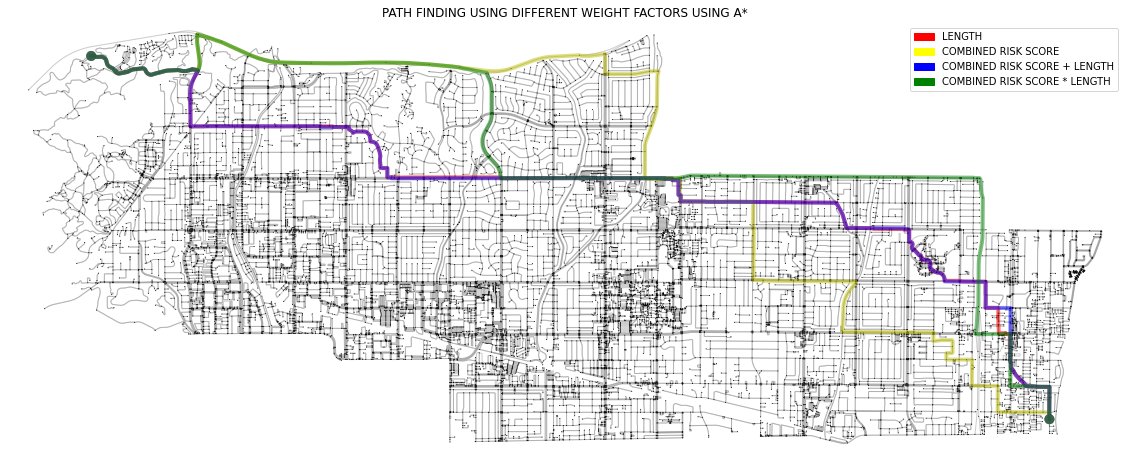

In [15]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "22801 Santa Susana Pass Rd, Chatsworth, CA 91311"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "8418 Noble Ave, North Hills, CA 91326"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)

# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,nodes_nr_all)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 8418 Noble Ave, North Hills, CA 91326

Finding Path using weight: length
LENGTH OF THE ROUTE 17457.553000000007
RISK OF THE ROUTE 600.9927862460116
Finding Path using weight: combined_risk_score
LENGTH OF THE ROUTE 19457.828999999994
RISK OF THE ROUTE 177.9671747607231
Finding Path using weight: combined_risk_and_length
LENGTH OF THE ROUTE 17236.662000000004
RISK OF THE ROUTE 454.2940978376458
Finding Path using weight: combined_risk_per_length
LENGTH OF THE ROUTE 18353.869999999995
RISK OF THE ROUTE 264.62679900744416


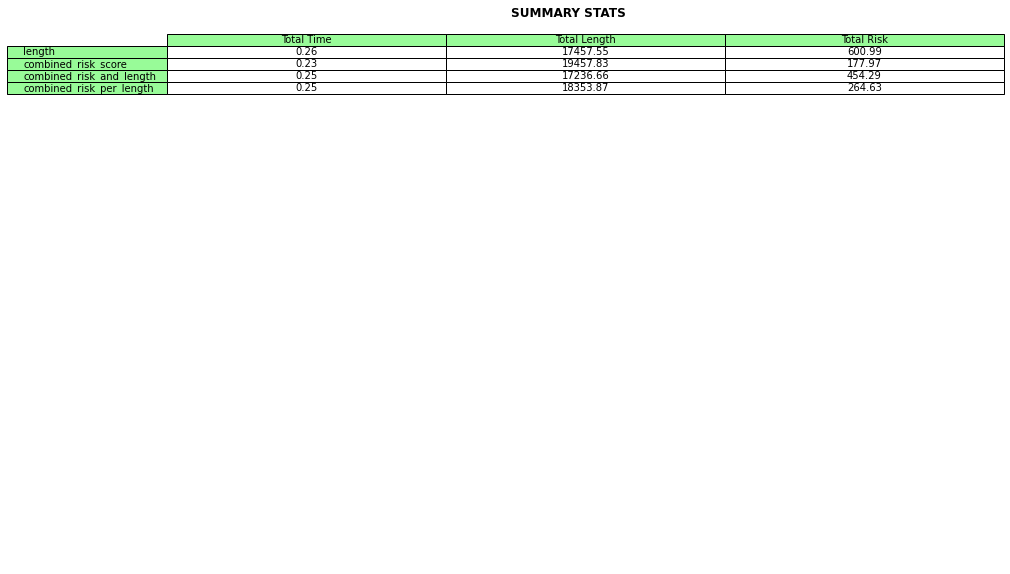

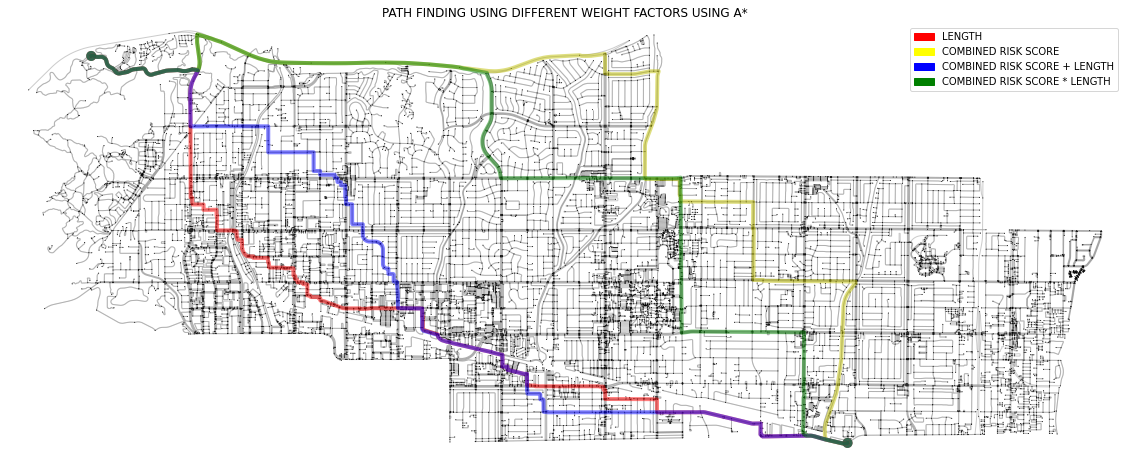

In [16]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "22801 Santa Susana Pass Rd, Chatsworth, CA 91311"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "7741 Hayvenhurst Ave, Van Nuys, CA 91406"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,nodes_nr_all)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

DEMO 2 - 
FIND PATH FOR NEAREST PARK


Finding Path using weight: length
LENGTH OF THE ROUTE 610.6160000000001
RISK OF THE ROUTE 12.062389223679546
Finding Path using weight: combined_risk_score
LENGTH OF THE ROUTE 610.6160000000001
RISK OF THE ROUTE 12.062389223679546
Finding Path using weight: combined_risk_and_length
LENGTH OF THE ROUTE 610.6160000000001
RISK OF THE ROUTE 12.062389223679546
Finding Path using weight: combined_risk_per_length
LENGTH OF THE ROUTE 610.6160000000001
RISK OF THE ROUTE 12.062389223679546


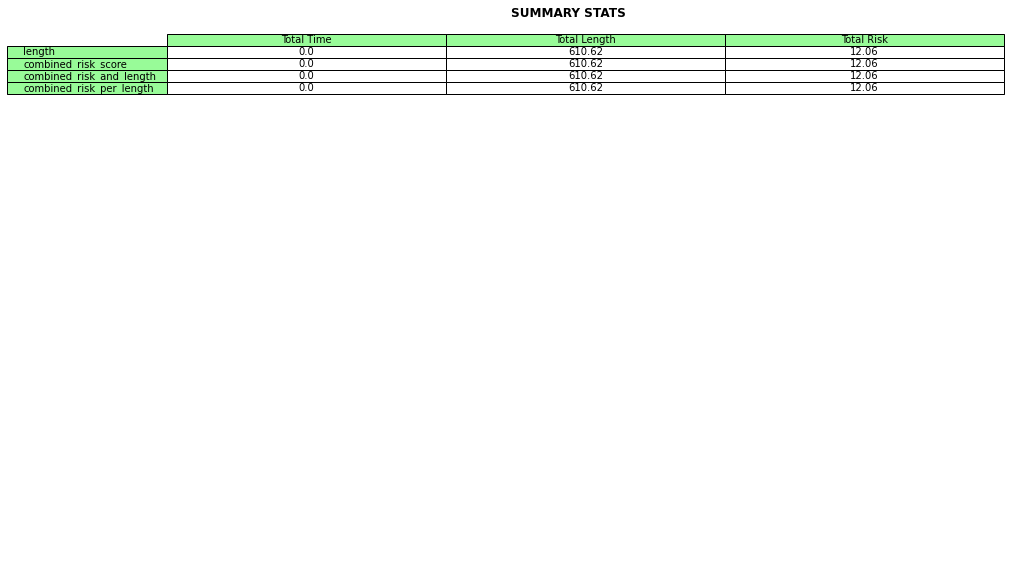

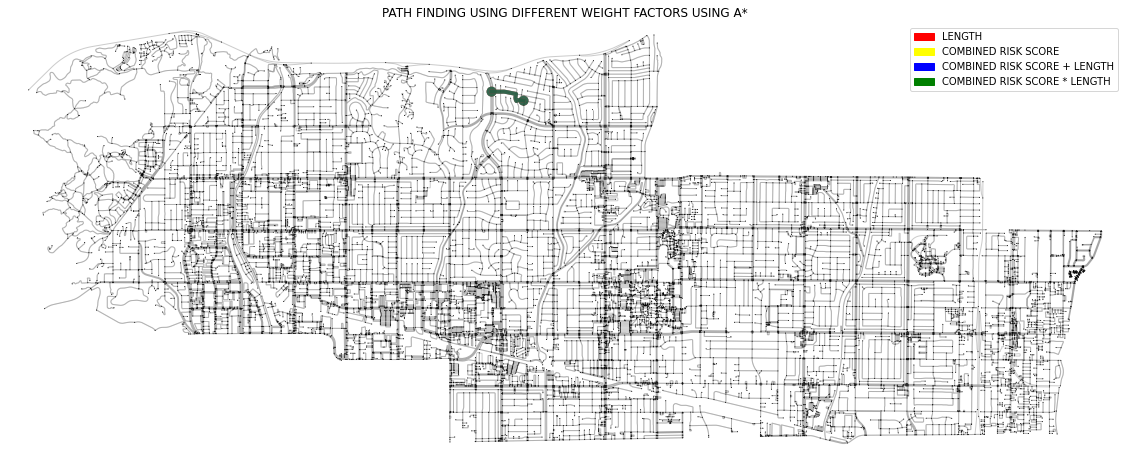

In [17]:
###### MAIN FUNCTION - NEAREST PARK #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 1
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_coordinates = ''

# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,nodes_nr_all)


DEMO 3 - 
FIND PATH FOR NEAREST SHELTER

Finding Path using weight: length
LENGTH OF THE ROUTE 3470.8469999999998
RISK OF THE ROUTE 36.411768876285
Finding Path using weight: combined_risk_score
LENGTH OF THE ROUTE 3470.8469999999998
RISK OF THE ROUTE 36.411768876285
Finding Path using weight: combined_risk_and_length
LENGTH OF THE ROUTE 3470.8469999999998
RISK OF THE ROUTE 36.411768876285
Finding Path using weight: combined_risk_per_length
LENGTH OF THE ROUTE 3948.7129999999997
RISK OF THE ROUTE 50.25404112017017


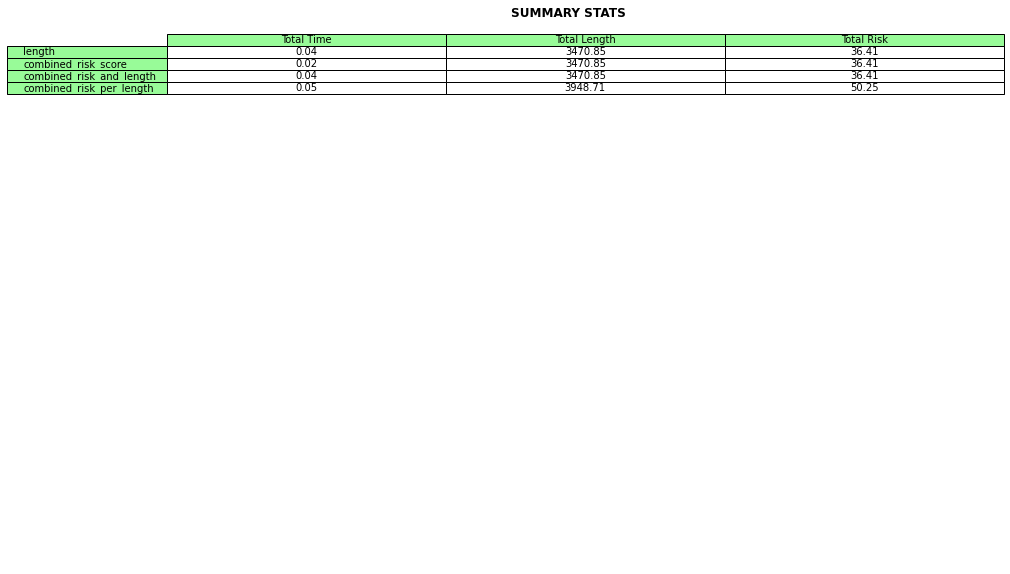

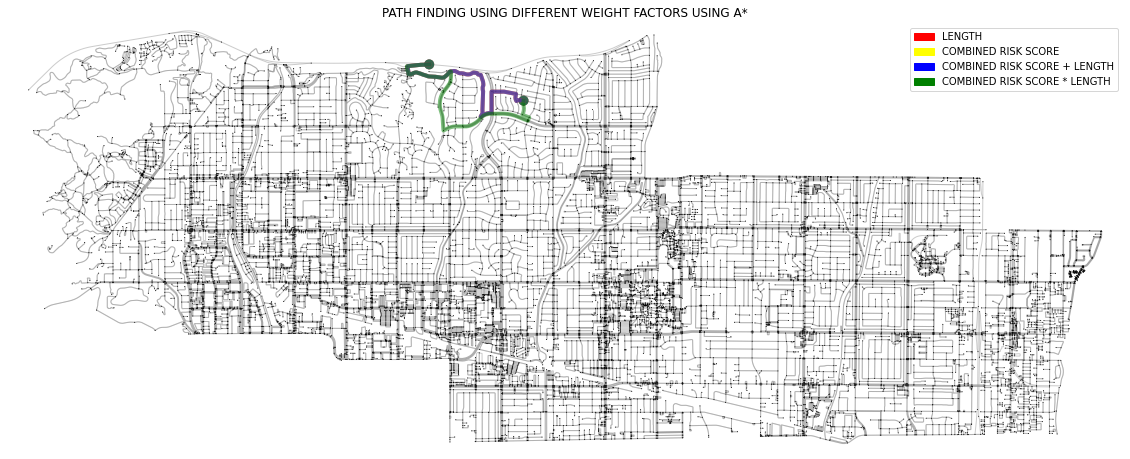

In [18]:
###### MAIN FUNCTION - NEAREST SHELTER #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 2
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_coordinates = ''
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,nodes_nr_all)